# End-to-end DSPy Workflows Guide 

Time to complete: 1 hour

## Building an Efficient LLM Pipeline with DSPy and Anyscale

In this guide, we'll show how you can build an efficient pipeline covering synthetic data generation, data processing, fine-tuning, evaluation and serving with DSPy and Anyscale. 

## Why DSPy and Anyscale?
DSPy simplifies the complex workflow of:
- Data Collection/Labeling
- Fine-tuning
- Prompt Optimization
- Evaluation
  
We'll use Anyscale for scalable infrastructure for training and serving/deploying models.

## Scenario: Cost-Effective Customer Support Query Classification

Consider an example of classification with limited labelled data. The specific dataset we'll be working with is the [PolyAI/banking77](https://huggingface.co/datasets/PolyAI/banking77) dataset, which consists of customer support queries for a bank. We'll simulate a scenario with low labelled data: let's say we have a dataset has limited labeled data (100 queries) and 4,000 unlabeled customer queries. We'll build a solution that leverages DSPy on Anyscale to distill knowledge from a 70B model into a more cost-effective 1B model, making it practical for production deployment.

- DSPy enables easy creation of a pipeline for knowledge distillation from a 70B model to a 1B model in a low data environment
- Anyscale's infrastructure supports efficient fine-tuning and deployment
- Result: A cost-effective, accurate classification system for 25 categories

## Table of Contents

1. Setup
2. Data Processing and Labeling
3. Model Fine-tuning
4. Evaluation and Optimization
5. Production Deployment
6. Future Improvements

## Set up

We will be running everything on A100-80GB GPUs. This is not necessary, especially for running a 1B model. You can edit the serving configuration files used throughout the notebook to use different GPUs if you do not have access to A100s.

We use Anyscale's Auto-select worker node feature to launch and manage child nodes that are running our LLM. You can also set your own compute configuration to autoscale different types of GPUs at different ranges.

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import importlib.util

if importlib.util.find_spec("dspy") is None:
    print("Installing dspy")
    !pip install git+https://github.com/stanfordnlp/dspy.git@anyscale-ft-updates

else:
    print("dspy is already installed")

!pip install matplotlib python-dotenv

Installing dspy
  Cloning https://github.com/stanfordnlp/dspy.git (to revision anyscale-ft-updates) to /tmp/pip-req-build-oc8hwbky
  Running command git clone --filter=blob:none --quiet https://github.com/stanfordnlp/dspy.git /tmp/pip-req-build-oc8hwbky
  Running command git checkout -b anyscale-ft-updates --track origin/anyscale-ft-updates
  Switched to a new branch 'anyscale-ft-updates'
  Branch 'anyscale-ft-updates' set up to track remote branch 'anyscale-ft-updates' from 'origin'.
  Resolved https://github.com/stanfordnlp/dspy.git to commit 027b1c540236e65ef1d1d7e6b2a8a2de6c43f515
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 147.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.4/597.4 kB 37.4 MB/s eta 0:00:00
  Created wheel for dspy: filename=ds

In order to run this notebook, you need to have the following environment variables set:
- HF_HOME=/mnt/local_storage/huggingface (By default, the cache directory used by HuggingFace is in the home directory -`/home/ray` in this workspace. We'll use `/mnt/local_storage` here for downloading large model weight files)
- HF_TOKEN
- (optional) WANDB_API_KEY

You can get a HF_TOKEN [here](https://huggingface.co/settings/tokens). You will need to request access to the Meta-Llama-3.1-70B-Instruct model and the Llama-3.2-1B-Instruct model.

You can get a WANDB_API_KEY [here](https://wandb.ai/authorize).

In [2]:
import dspy
dspy.settings.configure(experimental=True)

import ujson

from src import set_dspy_cache_location
set_dspy_cache_location("/home/ray/default/dspy/cache")

<b style="background-color: yellow;">&nbsp;🔄 REPLACE&nbsp;</b>: Set the HF_TOKEN, HF_HOME, and optionally the WANDB_API_KEY environment variables in the notebook.

In [3]:
import os
import ray 

os.environ["HF_HOME"] = "/mnt/local_storage/huggingface"
os.environ["HF_TOKEN"] = "Add your HF Token here"
# Optional: Add your Wandb token
# os.environ["WANDB_API_KEY"] = "12345"

# You can also use a .env file to store your HF_TOKEN and WANDB_API_KEY
# from dotenv import load_dotenv
# load_dotenv()

In [4]:
# Initialize ray
from src import check_env_vars
from src import init_ray

# Check if env vars are set correctly
check_env_vars()


# initialize ray
init_ray()

2024-10-22 02:42:08,272	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.0.121:6379...
2024-10-22 02:42:08,279	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-rvjx58jmwrc9n3vi27hu8y4rr8.i.anyscaleuserdata.com 
2024-10-22 02:42:08,308	INFO packaging.py:531 -- Creating a file package for local directory '/home/ray/anaconda3/lib/python3.9/site-packages/dspy'.
2024-10-22 02:42:08,350	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_80c4e27190bc727d.zip' (1.17MiB) to Ray cluster...
2024-10-22 02:42:08,364	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_80c4e27190bc727d.zip'.
2024-10-22 02:42:08,383	INFO packaging.py:531 -- Creating a file package for local directory '/home/ray/anaconda3/lib/python3.9/site-packages/dsp'.
2024-10-22 02:42:08,406	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_e4fe56ade2d2c5fb.zip' (0.55MiB) to Ray cluster...
2024-10-22 02:42:08,410	INFO packag

(autoscaler +19m16s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


We will make use of a random number generator in this notebook to ensure that our notebook is reproducible.

In [5]:
from src import set_random_seed
rng = set_random_seed()

We will be using the `PolyAI/banking77` dataset for this tutorial. We use the built in dspy DataLoader to load the dataset from Huggingface as a list of dspy.Example objects.

In [6]:
%%capture
# Prepare the dataset
from src import load_data_from_huggingface, convert_int_label_to_string
full_trainset, full_testset = load_data_from_huggingface()

full_trainset_processed, full_testset_processed = convert_int_label_to_string(full_trainset, full_testset)

The dataset is originally called "banking77" because there are 77 labels. We will be reducing this to the top 25 most frequent labels.

In [7]:
from src import filter_to_top_n_labels
full_trainset_filtered, full_testset_filtered, top_25_labels = filter_to_top_n_labels(full_trainset_processed, full_testset_processed, n=25)

print(f"Dataset filtered to top 25 labels. New sizes:")
print(f"Training set size: {len(full_trainset_filtered)}; Test set size: {len(full_testset_filtered)}")
print(f"Top 25 labels: {', '.join(str(label) for label in top_25_labels)}")
print(f"Example training set: {full_trainset_filtered[0]}")
print(f"Example test set: {full_testset_filtered[0]}")

Dataset filtered to top 25 labels. New sizes:
Training set size: 4171; Test set size: 1000
Top 25 labels: card_payment_fee_charged, direct_debit_payment_not_recognised, balance_not_updated_after_cheque_or_cash_deposit, wrong_amount_of_cash_received, cash_withdrawal_charge, transaction_charged_twice, declined_cash_withdrawal, transfer_fee_charged, balance_not_updated_after_bank_transfer, transfer_not_received_by_recipient, request_refund, card_payment_not_recognised, card_payment_wrong_exchange_rate, extra_charge_on_statement, wrong_exchange_rate_for_cash_withdrawal, refund_not_showing_up, reverted_card_payment, cash_withdrawal_not_recognised, activate_my_card, pending_card_payment, cancel_transfer, beneficiary_not_allowed, card_arrival, declined_card_payment, pending_top_up
Example training set: Example({'label': 'card_arrival', 'text': 'I am still waiting on my card?'}) (input_keys={'text'})
Example test set: Example({'label': 'card_arrival', 'text': 'How do I locate my card?'}) (inpu

In [8]:
labels_in_use = top_25_labels
print(labels_in_use)

['card_payment_fee_charged', 'direct_debit_payment_not_recognised', 'balance_not_updated_after_cheque_or_cash_deposit', 'wrong_amount_of_cash_received', 'cash_withdrawal_charge', 'transaction_charged_twice', 'declined_cash_withdrawal', 'transfer_fee_charged', 'balance_not_updated_after_bank_transfer', 'transfer_not_received_by_recipient', 'request_refund', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'extra_charge_on_statement', 'wrong_exchange_rate_for_cash_withdrawal', 'refund_not_showing_up', 'reverted_card_payment', 'cash_withdrawal_not_recognised', 'activate_my_card', 'pending_card_payment', 'cancel_transfer', 'beneficiary_not_allowed', 'card_arrival', 'declined_card_payment', 'pending_top_up']


Now we will shuffle our training set and split it into a training and labeled set.

The scenario we are emulating is that we only have 100 labeled examples to train on. We are saying that we have 4K (length of the training set) unlabeled examples we can then label using an oracle model, and then distill the knowledge from the oracle model into our 1B model.

In [9]:
from src import adjusted_exact_match, delete_labels, NUM_THREADS

common_kwargs = dict(metric=adjusted_exact_match, num_threads=NUM_THREADS, display_progress=True, max_errors=10000)

shuffled_trainset = [d for d in full_trainset_filtered]
rng.shuffle(shuffled_trainset)

# The devset shouldn't overlap
ft_trainset = shuffled_trainset[:-100]
labeled_trainset = shuffled_trainset[-100:]

# For realism of this scenario, we are going to delete all our labels except for our test set(which is cheating and we wouldn't have in production) and our 100 true labeled examples
ft_trainset_to_label = delete_labels(ft_trainset)

testset = full_testset_filtered
evaluate_testset = dspy.Evaluate(devset=testset, **common_kwargs)

# Implementing a Simple Chain of Thought Program in DSPy

## Defining the Signature

At the heart of our DSPy program is the `Signature` class. This class serves as a blueprint, outlining the inputs and outputs of our language model task. Here's how we structure it:

1. **Docstring for Context**: We utilize the docstring to provide context to the LLM. In this case, we're passing our fixed set of 25 labels directly in the docstring. This approach is ideal when dealing with a static set of options.

2. **Input Field**: We define an `intent` field as the input to our program. This will contain the natural language query we want to classify.

3. **Output Field**: The `label` field represents our desired output - the classified intent.

Both input and output fields are accompanied by concise descriptions, just to help the LLM understand the task.

By structuring our program this way, we utilize DSPy's capabilities to create a clear, modular design that's both powerful and easy to maintain. 

In [11]:
class IntentClassification(dspy.Signature):
    """As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.
    The intent should exactly match one of the following:
    ['card_payment_fee_charged', 'direct_debit_payment_not_recognised', 'balance_not_updated_after_cheque_or_cash_deposit', 'wrong_amount_of_cash_received', 'cash_withdrawal_charge', 'transaction_charged_twice', 'declined_cash_withdrawal', 'transfer_fee_charged', 'balance_not_updated_after_bank_transfer', 'transfer_not_received_by_recipient', 'request_refund', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'extra_charge_on_statement', 'wrong_exchange_rate_for_cash_withdrawal', 'refund_not_showing_up', 'reverted_card_payment', 'cash_withdrawal_not_recognised', 'activate_my_card', 'pending_card_payment', 'cancel_transfer', 'beneficiary_not_allowed', 'card_arrival', 'declined_card_payment', 'pending_top_up']
    """

    intent = dspy.InputField(desc="Intent of the query")
    label = dspy.OutputField(desc="Type of the intent; Should just be one of the 25 labels with no other text")

For the module, we create a dspy.Module class that contains the Chain of Thought predictor using the signature we defined above.
We also pass in the valid labels to the module.

Inside the forward method, we pass the text to the predictor, do a little cleaning, and return the prediction.

In [12]:
class IntentClassificationModule(dspy.Module):
    def __init__(self, labels_in_use):
        self.intent_classifier = dspy.ChainOfThought(IntentClassification)
        self.valid_labels = set(labels_in_use)

    def forward(self, text):
        prediction = self.intent_classifier(intent=text)
        sanitized_prediction = dspy.Prediction(label=prediction.label.lower().strip().replace(" ", "_"), reasoning=prediction.reasoning)
        return sanitized_prediction

Lastly, we set up some the vanilla program we will use throughout the notebook.

In [13]:
from src import MODEL_PARAMETERS, LOCAL_API_PARAMETERS
vanilla_program = IntentClassificationModule(labels_in_use)

In [15]:
# Note: Run above this to do all setup without launching any models
# This is useful if you have already collected data and want to start from finetuning or from evaluation

# Deploying and Utilizing a 70B Language Model

This section outlines the process of deploying and utilizing a 70B parameter language model for data gathering and training. Key steps include:

1. Infrastructure: Leverage Anyscale's [RayLLM](https://docs.anyscale.com/llms/serving/intro) with "Auto-select worker nodes" for dynamically allocating GPUs.
2. Configuration: Use a pre-generated serve config file (created via `rayllm gen-config`) to configure the RayLLM instance.

Below we show the contents of the serve config and its corresponding model config file.

In [14]:
import yaml
from src import get_serve_and_model_config, update_serve_config_hf_token

get_serve_and_model_config("serve_70B.yaml")
# update with custom HF_TOKEN
update_serve_config_hf_token("serve_70B.yaml")

serve_70B.yaml:
applications:
- args:
    llm_configs:
    - ./model_config/meta-llama--Meta-Llama-3_1-70B-Instruct.yaml
  import_path: rayllm:app
  name: llm-endpoint
  route_prefix: /
query_auth_token_enabled: false

model_config:
accelerator_type: A100-80G
deployment_config:
  autoscaling_config:
    initial_replicas: 1
    max_replicas: 2
    min_replicas: 0
    target_ongoing_requests: 128
  max_ongoing_requests: 300
engine_kwargs:
  enable_chunked_prefill: true
  max_num_batched_tokens: 8192
  max_num_seqs: 256
  tokenizer_pool_extra_config:
    runtime_env:
      pip: null
  tokenizer_pool_size: 2
  trust_remote_code: true
generation_config:
  prompt_format:
    assistant: '<|start_header_id|>assistant<|end_header_id|>


      {instruction}<|eot_id|>'
    bos: <|begin_of_text|>
    default_system_message: ''
    system: '<|start_header_id|>system<|end_header_id|>


      {instruction}<|eot_id|>'
    system_in_user: false
    trailing_assistant: '<|start_header_id|>assistant<|end

In [15]:
!serve run --non-blocking serve_70B.yaml

2024-10-22 02:53:37,037	INFO scripts.py:489 -- Running config file: 'serve_70B.yaml'.
2024-10-22 02:53:37,471	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.0.121:6379...
2024-10-22 02:53:37,476	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-rvjx58jmwrc9n3vi27hu8y4rr8.i.anyscaleuserdata.com 
2024-10-22 02:53:37,496	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_8f4c4880f4aa88b05e861dc41262ee76bfcd6688.zip' (7.25MiB) to Ray cluster...
2024-10-22 02:53:37,583	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_8f4c4880f4aa88b05e861dc41262ee76bfcd6688.zip'.
INFO 2024-10-22 02:53:37,621 serve 60009 api.py:259 - Connecting to existing Serve app in namespace "serve". New http options will not be applied.
2024-10-22 02:53:37,626	SUCC scripts.py:540 -- Submitted deploy config successfully.
(ServeController pid=9667) INFO 2024-10-22 02:53:37,625 controller 9667 application_state.py:457 - Imp

In [16]:
llama_70b = dspy.LM(model="openai/meta-llama/Meta-Llama-3.1-70B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

You can expect the cell below to take around 8-10 minutes to run, as it waits for the cluster to recruit a worker node if necessary and also downloads the 70B model weights.

In [17]:
from src import sanity_check_program

sanity_check_program(llama_70b, vanilla_program, ft_trainset[0])

Program input: Example({'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?'}) (input_keys={'text'})


NotFoundError: litellm.NotFoundError: NotFoundError: OpenAIException - Error code: 404 - {'generated_text': None, 'tool_calls': None, 'embedding_outputs': None, 'logprobs': None, 'num_input_tokens': None, 'num_input_tokens_batch': None, 'num_generated_tokens': None, 'num_generated_tokens_batch': None, 'preprocessing_time': None, 'generation_time': None, 'timestamp': 1729565927.9633803, 'finish_reason': None, 'error': {'message': 'Unable to find meta-llama/Meta-Llama-3.1-70B-Instruct. Please ensure that the model exists and you have permission. (Request ID: 183ca495-8542-4f30-8f02-50ec2f5718af)', 'internal_message': 'rayllm_oss.backend.server.openai_compat.openai_exception.OpenAIHTTPException (Request ID: 183ca495-8542-4f30-8f02-50ec2f5718af)', 'code': 404, 'type': 'OpenAIHTTPException', 'param': {}}}

### Bootstrap Data


In this section, we bootstrap data for fine-tuning.

We delete all the true labels to be accurate to the scenario, and then collect data from the oracle LLM.

We use a metric that checks if the prediction is in the set of labels we are using to get rid of any nonsense labels that the oracle LLM may hallucinate.

In [20]:
from dspy.teleprompt.finetune_teleprompter import bootstrap_data, convert_to_module_level_message_data
from src import delete_labels, NUM_THREADS, write_jsonl
from src.data_preprocess import valid_label_metric

with dspy.context(lm=llama_70b):
    collected_data = bootstrap_data(vanilla_program, ft_trainset_to_label, num_threads=NUM_THREADS, max_errors=10000, metric=valid_label_metric)
    # Make sure to only include the labels we are actively using or that arent hallucinated by the oracle
    collected_data_filtered = [x for x in collected_data if x["prediction"]["label"] in labels_in_use]
    
    dataset = convert_to_module_level_message_data(collected_data_filtered, program=vanilla_program, exclude_demos=True)

    dataset_formatted = [{"messages": item} for item in dataset]

print(dataset_formatted[0])
print("Length of dataset:\t", len(dataset))

Average Metric: 4065 / 4071  (99.9): 100%|██████████| 4071/4071 [06:49<00:00,  9.93it/s]


{'messages': [{'role': 'system', 'content': "Your input fields are:\n1. `intent` (str): Intent of the query\n\nYour output fields are:\n1. `reasoning` (str): ${produce the output fields}. We ...\n2. `label` (str): Type of the intent; Should just be one of the 25 labels with no other text\n\nAll interactions will be structured in the following way, with the appropriate values filled in.\n\n[[ ## intent ## ]]\n{intent}\n\n[[ ## reasoning ## ]]\n{reasoning}\n\n[[ ## label ## ]]\n{label}\n\n[[ ## completed ## ]]\n\nIn adhering to this structure, your objective is: \n        As a part of a banking issue traiging system, classify the intent of a natural language query into one of the 25 labels.\n        The intent should exactly match one of the following:\n        ['card_payment_fee_charged', 'direct_debit_payment_not_recognised', 'balance_not_updated_after_cheque_or_cash_deposit', 'wrong_amount_of_cash_received', 'cash_withdrawal_charge', 'transaction_charged_twice', 'declined_cash_withdra

In [ ]:
# Now we are done with the 70B model, so we can kill the server
!serve shutdown -y

# Fine-tuning

We will use LLM Forge to fine-tune the 1B model.

In order to do this, we need to format our data into the correct format (Follows OpenAI messaging format).

Anyscale now has a first class integration with DSPy for finetuning. Anyscale offers a tool for finetuning called LLMForge, which DSPy will interface with to do the actual finetuning using your own cluster on the task you defined above.

We can let DSPy do the rest, where it will properly generate the config and run the finetuning.

Be sure to checkout the fine-tuning documentation for the latest on how to use our [API](https://docs.anyscale.com/llms/finetuning/intro) and additional [capabilities](https://docs.anyscale.com/category/fine-tuning-beta/).

We'll fine-tune our LLM by choosing a set of configurations. We have created recipes for different LLMs in the [`training configs`](configs/training/lora/llama-3-8b.yaml) folder which can be used as is or modified for experiments. These configurations provide flexibility over a broad range of parameters such as model, data paths, compute to use for training, number of training epochs, how often to save checkpoints, padding, loss, etc. We also include several [DeepSpeed](https://github.com/microsoft/DeepSpeed) [configurations](configs/deepspeed/zero_3_offload_optim+param.json) to choose from for further optimizations around data/model parallelism, mixed precision, checkpointing, etc.

We also have recipes for [LoRA](https://arxiv.org/abs/2106.09685) (where we train a set of small low ranked matrices instead of the original attention and feed forward layers) or full parameter fine-tuning. We recommend starting with LoRA as it's less resource intensive and quicker to train.

In [21]:
from dspy.clients.lm import TrainingMethod
from src import load_finetuning_kwargs

train_data = dataset_formatted
method = TrainingMethod.SFT

finetuneable_lm = dspy.LM(model="meta-llama/Llama-3.2-1B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

try:
    finetuning_job = finetuneable_lm.finetune(train_data=train_data, train_kwargs=load_finetuning_kwargs(), train_method=method, provider="anyscale")
    finetuned_llama = finetuning_job.result()
except Exception as e:
    print(e)

Copying file:///home/ray/.dspy_cache/finetune/anyscale_02ce0cdfe3b0a1c7.jsonl to gs://storage-bucket-cld-tffbxe9ia5phqr1unxhz4f7e1e/org_4snvy99zwbmh4gbtk64jfqggmj/cld_tffbxe9ia5phqr1unxhz4f7e1e/artifact_storage/anyscale_02ce0cdfe3b0a1c7.jsonl
  
.
(anyscale +15m49.8s) Uploading local dir '.' to cloud storage.
(anyscale +15m52.7s) Job 'dspy-llmforge-fine-tuning-job' submitted, ID: 'prodjob_wpvi522nrlcn95jw5btvyn26bn'.
(anyscale +15m52.7s) View the job in the UI: https://console.anyscale.com/jobs/prodjob_wpvi522nrlcn95jw5btvyn26bn
(anyscale +15m52.8s) Waiting for job 'prodjob_wpvi522nrlcn95jw5btvyn26bn' to reach target state SUCCEEDED, currently in state: STARTING
(anyscale +17m46.0s) Job 'prodjob_wpvi522nrlcn95jw5btvyn26bn' transitioned from STARTING to RUNNING
(anyscale +38m41.9s) Job 'prodjob_wpvi522nrlcn95jw5btvyn26bn' transitioned from RUNNING to SUCCEEDED
(anyscale +38m41.9s) Job 'prodjob_wpvi522nrlcn95jw5btvyn26bn' reached target state, exiting


# Evaluation

## Performance comparisons

**Synthetic Devset:**
- 1B Non-finetuned
- 1B Non-finetuned + Prompt Optimization
- 1B Finetuned (last checkpoint)
- 1B Finetuned (last checkpoint) + Prompt Optimization

**Test set:**
- 1B Non-finetuned + Prompt Optimization
- 1B Finetuned (last checkpoint) + Prompt Optimization

Note that we do not provide an eval set when finetuning, as the eval loss of a checkpoint isn't necessarily predictive of the downstream performance of the program. We use the last checkpoint by default.

In [25]:
print(finetuned_llama.model)

openai/meta-llama/Llama-3.2-1B-Instruct:isaac:mgvdw


We will run a local RayLLM instance that serves the model.

Provided with this template is are two files, `serve_1B.yaml` and `\model_configs\meta-llama--Llama-3_2-1B-Instruct.yaml`. 

The first file, `serve_1B.yaml`, contains the serve configuration to load the model with RayLLM.

The second file, `\model_configs\meta-llama--Llama-3_2-1B-Instruct.yaml`, contains the necessary configurations to run the 1B model.

<b style="background-color: yellow;">&nbsp;🔄 REPLACE&nbsp;</b>:
Make sure you set your HF_TOKEN and HF_HOME environment variables in the workspace runtime environment variables, and run the following command to start the server:

In [26]:
from src import update_serve_config_hf_token

update_serve_config_hf_token("serve_1B.yaml")

Run this command to start the 1B RayLLM server:

In [39]:
!serve run --non-blocking serve_1B.yaml

2024-10-21 23:54:34,547	INFO scripts.py:489 -- Running config file: 'serve_1B.yaml'.
2024-10-21 23:54:34,846	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.0.48:6379...
2024-10-21 23:54:34,852	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-fkvdirx4bzefi53sjl55m7asad.i.anyscaleuserdata.com 
2024-10-21 23:54:34,871	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_89f1270a0f12aad17a8624b6b4057dceb301409b.zip' (8.74MiB) to Ray cluster...
2024-10-21 23:54:34,951	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_89f1270a0f12aad17a8624b6b4057dceb301409b.zip'.
INFO 2024-10-21 23:54:38,085 serve 83025 api.py:277 - Started Serve in namespace "serve".
2024-10-21 23:54:38,093	SUCC scripts.py:540 -- Submitted deploy config successfully.
(ServeController pid=83112) INFO 2024-10-21 23:54:38,089 controller 83112 application_state.py:881 - Deploying new app 'llm-endpoint'.
(ServeController pid=83112

In [40]:
from src import MODEL_PARAMETERS, LOCAL_API_PARAMETERS

non_ft_llama = dspy.LM(model="openai/meta-llama/Llama-3.2-1B-Instruct", **MODEL_PARAMETERS, **LOCAL_API_PARAMETERS)

all_llamas = {"base": non_ft_llama, "ft": finetuned_llama}

In [41]:
# Sanity check that the finetuned models are working

try:
    sanity_check_program(finetuned_llama, vanilla_program, ft_trainset[0])
    sanity_check_program(non_ft_llama, vanilla_program, ft_trainset[0])
except ValueError as e:
    # Sometimes the 1B model isn't capable of correctly outputting the label before prompt optimization, so we can just ignore this error.
    print(e)

Program input: Example({'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?'}) (input_keys={'text'})
Program output label: card_payment_not_recognised
Program input: Example({'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?'}) (input_keys={'text'})


Expected dict_keys(['reasoning', 'label']) but got dict_keys([])


We are going to be doing prompt optimization using DSPy's `BootstrapFewShotWithRandomSearch (BFRS)` function.

BFRS will:
- Collect a set of chains of thought from the oracle
- Use these examples that lead to a correct prediction to "bootstrap" the program
- See which set of examples lead to the most correct predictions across your evaluation metric
- Continue this process for a set number of iterations, using the best performing programs to bootstrap the next iteration
- Return the best program

Let's go over what the hyperparameters mean:
- **max_bootstrapped_demos**: DSPy will "bootstrap" the program by collecting examples at each step that are successful and reusing those in the pipeline. This means that it will automatically collect and add chains of thought to the pipeline.
- **max_labeled_demos**: DSPy will also insert some labeled demonstrations from the training set. These would be unmodified examples from the training set that are just using the given answer.
- **num_candidate_programs**: This is the number of candidate programs that the optimizer will generate. The actual number of programs that are created is this plus three, as DSPy will also try a program with no examples, a program with just the labeled demonstrations, and a bootstrapped program with the first few examples.


In [32]:
from src import bootstrap_fewshot_random_search_parameters, metric

print("Parameters:")
for k, v in bootstrap_fewshot_random_search_parameters.items():
    print(f"{k}: {v}")

Parameters:
max_bootstrapped_demos: 3
max_labeled_demos: 3
num_candidate_programs: 6


In [33]:
from src import split_into_devset_and_optimizer_sets

def collected_data_to_example(data):
    return dspy.Example(text=data["example"]["text"], label=data["prediction"]["label"]).with_inputs("text")

collected_data_examples = [collected_data_to_example(x) for x in collected_data_filtered]

devset_synthetic, ft_optimizer_trainset, ft_optimizer_devset = split_into_devset_and_optimizer_sets(collected_data_examples, dev_size=1000, optimizer_num_val=300)
print("Lengths:")
print("Synthetic Devset:\t", len(devset_synthetic))
print("Optimizer Trainset:\t", len(ft_optimizer_trainset))
print("Optimizer Devset:\t", len(ft_optimizer_devset))
print("Example from synthetic devset:")
print(devset_synthetic[0])

Lengths:
Synthetic Devset:	 1000
Optimizer Trainset:	 2762
Optimizer Devset:	 300
Example from synthetic devset:
Example({'text': 'I still have not received an answer as to why I was charged $1.00 in a transaction?', 'label': 'extra_charge_on_statement'}) (input_keys={'text'})


Now we will our finetuned model and the base model, prompt optimize them, and evaluate them on the synthetic devset.

Note that there is a `%%capture` below. This is to suppress the output of the evaluation and prompt optimization because it is quite long and will slow down the notebook. We will graph the results in the cell after. You can remove the tag in order to see the output.

You can expect this to take around 15 minutes to run.

In [1]:
# %%capture
from src import evaluate_and_prompt_optimize

evaluation_kwargs = {
    "models": all_llamas,
    "module_class": IntentClassificationModule,
    "optimizer_trainset": ft_optimizer_trainset,
    "optimizer_valset": ft_optimizer_devset,
    "devset": devset_synthetic,
    "metric": metric,
    "labels_in_use": labels_in_use
}

ft_results = evaluate_and_prompt_optimize(**evaluation_kwargs)

ModuleNotFoundError: No module named 'dspy'

In [2]:
if True:
    import json
    with open("ft_results.json", "w") as f:
        json.dump(ft_results, f)
else:
    ft_results = json.load(open("ft_results.json"))

NameError: name 'ft_results' is not defined

In [43]:
print(ft_results)

{'base': {'vanilla': {'devset': 0.0}, 'bfrs': {'devset': 34.6}}, 'ft': {'vanilla': {'devset': 55.3}, 'bfrs': {'devset': 55.3}}}


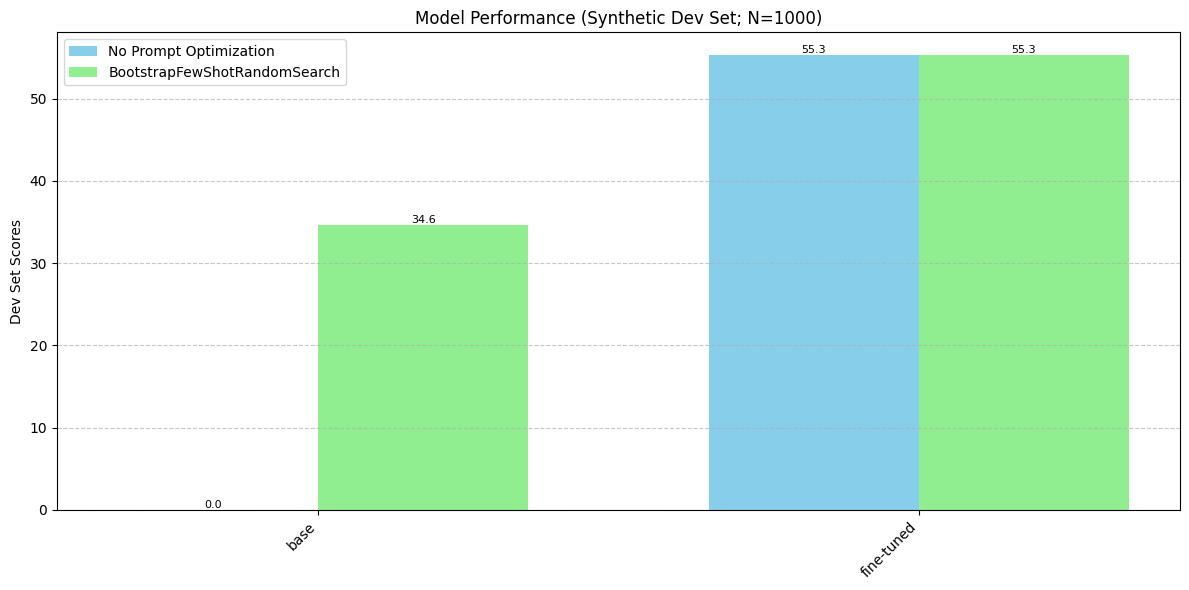

Highest Dev Set Score: 55.3, Model: fine-tuned


In [44]:
from src import graph_devset_results, graph_testset_results

graph_devset_results(ft_results)

We see that the highest performing model is the final epoch with a score of 50.2 on our synthetic devset.

We will now take this best performing model and evaluate it and our prompt optimized base model on the true test set to see if we have improved performance.

This should take around 10 minutes to run.

In [34]:
%%capture
# Now we need to evaluate the test set
from src import run_testset_evaluation

testset_evaluation_kwargs = {
    "ft_results": ft_results,
    "all_llamas": all_llamas,
    "labels_in_use": labels_in_use,
    "testset": testset,
    "metric": metric,
    "module_class": IntentClassificationModule
}

ft_results_testset, (best_program_path, best_model, best_score) = run_testset_evaluation(**testset_evaluation_kwargs)

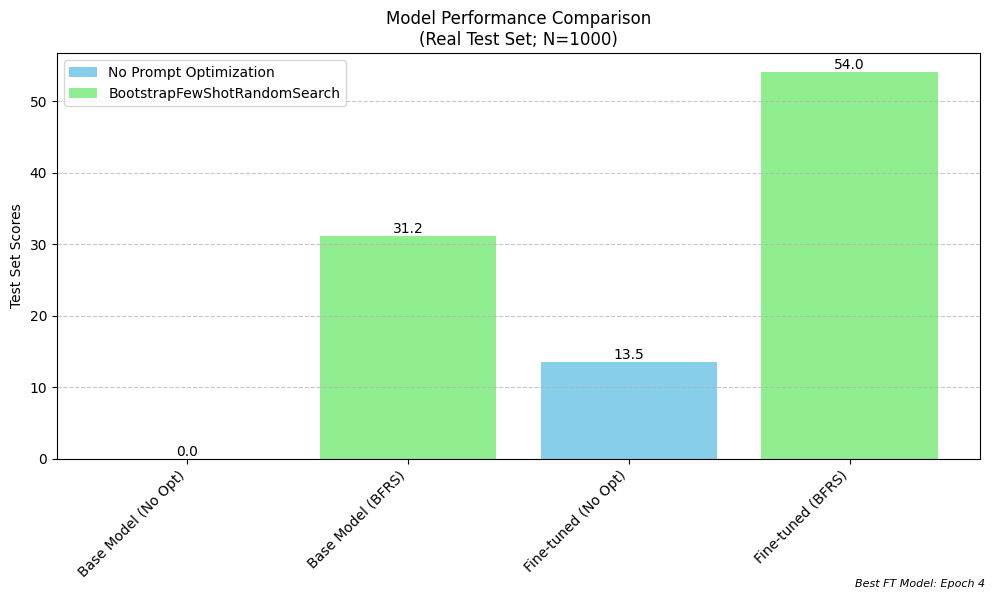

In [35]:
graph_testset_results(ft_results_testset)

In [36]:
print(f"Best testset result: \n{best_model} with score: {best_score}")

Best testset result: 
meta-llama/Llama-3.2-1B-Instruct:epochs-4-total-trained-steps-160 with score: 54.0


# Serving

# TODO: Add context about what we are doing

<b style="background-color: blue;">&nbsp;🔄 RUN (optional)&nbsp;</b>:
You can optionally deploy your model to Anyscale in order to use it in production.
To do this, run the following command:

```
!anyscale service deploy -f serve_1B.yaml
```

Follow the URL in order to find your service URL and API key for your deployed service.

If you choose not to deploy your model, you can run the following code to run the model locally.
```
serve run serve_1B.yaml
```

If you never took down your service from the previous section, there is no need to rerun the service run command.

In [ ]:
# !anyscale service deploy -f serve_1B.yaml
# !serve run serve_1B.yaml

<b style="background-color: yellow;">&nbsp;🔄 REPLACE&nbsp;</b>:
Replace the following variables with your Anyscale service URL and API key.

```
ANYSCALE_SERVICE_BASE_URL = None
ANYSCALE_API_KEY = None
```

You can find them by clicking the query button on the Anyscale dashboard for your service.

<!-- <img src="files/service-query.png" alt="Service Query" width="500"> -->
![Service Query](README_files/service-query.png)

In [37]:
ANYSCALE_SERVICE_BASE_URL = None
ANYSCALE_API_KEY = None

In [38]:
from src import MODEL_PARAMETERS, LOCAL_API_PARAMETERS
if ANYSCALE_SERVICE_BASE_URL and ANYSCALE_API_KEY:
    API_PARAMETERS = {"api_base": ANYSCALE_SERVICE_BASE_URL, "api_key": ANYSCALE_API_KEY}
else:
    API_PARAMETERS = LOCAL_API_PARAMETERS

Now we can use ray serve in order to deploy our DSPy program.

The RayLLM instance you deployed will autoscale according to the number of requests you make based on the configuration inside of the `serve_1B.yaml` file.

Ray serve does all the hard work for you there, so all you need to do is provide the URL and API key to query your model.

Now to deploy the DSPy program on top of the RayLLM instance, we can create a FastAPI wrapper around our DSPy program.

In [89]:
from ray import serve
from fastapi import FastAPI

app = FastAPI()

@serve.deployment(
    ray_actor_options={"num_cpus": 0.1},
    autoscaling_config=dict(min_replicas=1, max_replicas=3)
)
@serve.ingress(app)
class LLMClient:
    def __init__(self):
        self.llm = dspy.LM(model="openai/" + best_model, **MODEL_PARAMETERS, **API_PARAMETERS)
        dspy.settings.configure(experimental=True, lm=self.llm)
        self.program = IntentClassificationModule(labels_in_use)
        self.program.load(best_program_path)

    @app.get("/")
    async def classify_intent(
        self,
        query: str,
    ):
        """Answer the given question and provide sources."""
        retrieval_response = self.program(query)

        return retrieval_response.label

llm_client = LLMClient.bind()
llm_handle = serve.run(llm_client, route_prefix="/classify_intent", name="llm_client")

INFO 2024-10-19 01:34:51,639 serve 14470 api.py:259 - Connecting to existing Serve app in namespace "serve". New http options will not be applied.
WARNING 2024-10-19 01:34:51,641 serve 14470 api.py:85 - The new client HTTP config differs from the existing one in the following fields: ['host']. The new HTTP config is ignored.


INFO 2024-10-19 01:34:57,689 serve 14470 client.py:492 - Deployment 'LLMClient:xrueus8l' is ready at `http://0.0.0.0:8000/classify_intent`. component=serve deployment=LLMClient
INFO 2024-10-19 01:34:57,692 serve 14470 api.py:549 - Deployed app 'llm_client' successfully.


In [82]:
example_query = ft_trainset[1]["text"]
llm_response = await llm_handle.classify_intent.remote(
    query=example_query,
)
print(example_query)
print(llm_response)

My card was charged more than expected.
card_payment_fee_charged


We can also query directly using HTTP requests, because we use the `@app` decorator on our FastAPI app.

In [91]:
import requests
try:
    response = requests.get(f"http://localhost:8000/classify_intent?query={example_query}")
    print(response.json())
except Exception as e:
    print(e)

card_payment_fee_charged


<b style="background-color: yellow;">&nbsp;🛑 IMPORTANT&nbsp;</b>: Please `Terminate` your service from the Service page to avoid depleting your free trial credits.

In [ ]:
# Clean up
!python src/clear_cell_nums.py
!find . | grep -E ".ipynb_checkpoints" | xargs rm -rf
!find . | grep -E "(__pycache__|\.pyc|\.pyo)" | xargs rm -rf
!rm -rf __pycache__ data .HF_TOKEN deploy/services